# Assignment 4: Recommenders

In [52]:
import pandas as pd

# Load the datasets as pandas DataFrames
dataset = pd.read_csv("dataset.csv")
test = pd.read_csv("recommend.csv")

N_RECOMMENDATIONS = 10

dataset.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 02:33:18+00:00,view,5649270,1487580013749338323,NaN,concept,6.19,580009457,aab91835-f131-4f1d-8ffd-6738e703ead3
1,2019-12-01 02:34:27+00:00,view,5844146,1783999067156644376,NaN,NaN,8.06,580009457,aab91835-f131-4f1d-8ffd-6738e703ead3
2,2019-12-01 02:34:55+00:00,cart,5844146,1783999067156644376,NaN,NaN,8.06,580009457,aab91835-f131-4f1d-8ffd-6738e703ead3
3,2019-12-01 02:35:10+00:00,cart,5844146,1783999067156644376,NaN,NaN,8.06,580009457,aab91835-f131-4f1d-8ffd-6738e703ead3
4,2019-12-01 02:35:15+00:00,remove_from_cart,5844146,1783999067156644376,NaN,NaN,8.06,580009457,aab91835-f131-4f1d-8ffd-6738e703ead3


In [53]:
# Leave one purchased item out per user for predicting the hitrate
purchased_products = dataset[dataset.event_type == "purchase"]
leftouts = purchased_products.sample(frac=1.0).groupby('user_id').head(1)
leftouts.head()
# Get index of the leftout items
leftout_index = leftouts.index.values
# Drop the leftout items from the dataset
train_data = dataset.drop(leftout_index)
test_data = leftouts

# Same recommendations for each user
For this, we'll just use popularity on the purchased products

In [54]:
def get_top_n_purchases(data, n, include_popular_product_df=False):
    # Filter only purchased products (event_type is purchased)
    purchased_products = data[data.event_type == "purchase"]

    # Get the 10 most popular purchased product_ids from those purchased products
    popular_products = purchased_products.groupby('product_id')['product_id'].count().reset_index(
        name="count").sort_values(ascending=False, by="count")

    total_bought = len(purchased_products)
    popular_products["percentage"] = popular_products["count"] / total_bought

    if include_popular_product_df:
        return popular_products[:n], popular_products

    return popular_products[:n]


In [21]:
top10 = get_top_n_purchases(dataset, N_RECOMMENDATIONS)
top10["product_id"].to_csv("baseline.csv", index=False, header=True)
top10

,product_id,count
3951,5809910,239
3341,5790689,172
927,5649236,146
1209,5677043,146
3337,5790563,108
1593,5692527,101
2578,5759492,97
254,19162,96
2649,5764716,90
2405,5751383,87


In [25]:
# Get the sum of the count column in top10
top10_times_bought = sum(top10["count"])
# Total numbers of items bought (number of rows in purchsed products)
total_bought = len(dataset[dataset.event_type == "purchase"])
# Percentage of purchased items that are in the top10 popular purchased items
percentage_top10 = top10_times_bought / total_bought
print(
    f"{percentage_top10 * 100:.2f}% (={top10_times_bought}/{total_bought}) of the purchased items are in the top {N_RECOMMENDATIONS} most popular purchased items")

5.07% (=1282/25287) of the purchased items are in the top 10 most popular purchased items


It is possible that 0% of the new bought items are in this top 10, but it's also possible 100% of those items are, but that's probably an unreasnable upper and lower limit.


In [31]:
purchased_products = dataset[dataset.event_type == "purchase"]
popular_products = purchased_products.groupby('product_id')['product_id'].count().reset_index(name="count").sort_values(
    ascending=False, by="count")

# Add column to popular_items with the percentage of times each product was bought
popular_products["percentage"] = popular_products["count"] / total_bought
popular_products.sample(10)

,product_id,count,percentage
5551,5846758,1,0.000040
5630,5848084,2,0.000079
7709,5884578,9,0.000356
3777,5806151,1,0.000040
5207,5840289,1,0.000040
7296,5875763,1,0.000040
7716,5885136,3,0.000119
3947,5809895,1,0.000040
512,5549798,1,0.000040
5465,5844907,3,0.000119


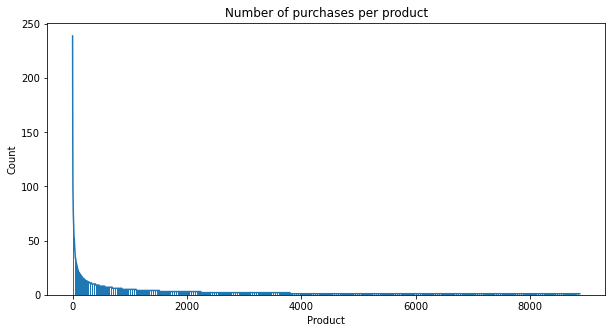

In [52]:
import matplotlib.pyplot as plt


def plot_popular_products(popular_products):
    # Plot popular_products with the discrete products on x axis and count on y axis
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(popular_products)), popular_products["count"])
    plt.bar(x=range(len(popular_products)), height=popular_products["count"])
    plt.xlabel("Product")
    plt.ylabel("Count")
    plt.title("Number of purchases per product")
    plt.show()


plot_popular_products(popular_products)

> For  this  baseline  recommender,  how  often  do  you  expect  someone  to  buy  the  item  you’ve recommended, can you give a reasonable upper or lower limit?

Given the chance (5.07%) that an item is bought, you would expect only one person to buy it for every 20 persons it get's recommended to. No idea how to give an upper or lower limit for this.

# Recommendations based on association rules


In [55]:
from association_rules import get_association_rules

# Reuse the association rules from assignment 4 (the ones that take views, cart, ... also in account on the left side of the association)
association_rules = get_association_rules(train_data,
                                          min_confidence=0.01)  # Chosen this confidence value, since  the most popular item is 1% of the total bought items, so this would probably be a better recommendation if the confidence is below this value

# Note: Those rules are NOT ordered
for rule in association_rules[:5]:
    print(rule)

Filtering min support: 100%|██████████| 25193/25193 [00:00<00:00, 2798164.89it/s]


Mining frequent itemsets of length 2


100%|██████████| 29111420/29111420 [00:29<00:00, 976040.52it/s] 


Mining frequent itemsets of length 3


100%|██████████| 14810952/14810952 [00:10<00:00, 1368467.04it/s]


Mining frequent itemsets of length 4


100%|██████████| 1886502/1886502 [00:01<00:00, 1277254.81it/s]


Mining frequent itemsets of length 5


100%|██████████| 92720/92720 [00:00<00:00, 1065704.63it/s]


Mining frequent itemsets of length 6


100%|██████████| 2070/2070 [00:00<00:00, 1033965.62it/s]


Mining frequent itemsets of length 7


100%|██████████| 2/2 [00:00<?, ?it/s]


{'cart5766390'} -> {'purchase5766379'} (0.14, 3)
{'cart5766377'} -> {'purchase5766379'} (0.38, 5)
{'purchase5766377'} -> {'purchase5766379'} (0.57, 4)
{'cart5809910'} -> {'purchase5751383'} (0.02, 4)
{'purchase5751383'} -> {'purchase5809910'} (0.07, 3)


In [56]:
from collections import defaultdict
from tqdm import tqdm
from association_rules import get_item_nr
import math

def update_recommendations_df(rule, recommendations_df, user_events):
    left_side: frozenset = rule.x
    right_side: frozenset = rule.y

    # Get the intersection of the left side and the user's events
    left_side_intersection = left_side.intersection(user_events)
    intersection_match = len(left_side_intersection) / len(left_side)

    if intersection_match == 0:
        # No match on the left side, so association rules is not relevant
        return recommendations_df

    # Using my own custom formula to calculate the recommendation score
    recommendation_score = rule.confidence * rule.sup * intersection_match

    for product_event in right_side:
        if product_event not in user_events:
            # Add the recommendation to the dataframe
            recommendations_df = recommendations_df.append(
                {'product_event': product_event, 'recommendation_score': recommendation_score},
                ignore_index=True)

    return recommendations_df

def get_user_recommendations(dataset, user_id, top10_list, association_rules):
    # Get all the purchased products for this user
    user_purchased_products = dataset[dataset.user_id == user_id]
    # Get the product_ids of the purchased products
    user_events = user_purchased_products.action_and_product_id.unique()
    # print(user_events)

    recommendations_df = pd.DataFrame(columns=['product_event', 'recommendation_score'])

    # Iterate over the association rules
    for rule in association_rules:
        recommendations_df = update_recommendations_df(rule, recommendations_df, user_events)

    # Sort the recommendations by recommendation score
    # Drop all rows with a score of 0, since the association rules aren't relevant for that and it's better to just use the top 10
    recommendations_df = recommendations_df.sort_values(by=['recommendation_score'], ascending=False)\
        .drop(recommendations_df[recommendations_df.recommendation_score == 0].index)

    # print(recommendations_df.head(N_RECOMMENDATIONS))

    recommendation_df_top = recommendations_df.product_event.unique()[:N_RECOMMENDATIONS]

    association_rule_based_recommendations = list(get_item_nr(item) for item in recommendation_df_top)

    items_missing = N_RECOMMENDATIONS - len(association_rule_based_recommendations)

    if association_rule_based_recommendations:  # Since it's often empty, keep the empty case efficient
        i = 0
        while len(association_rule_based_recommendations) < N_RECOMMENDATIONS:
            if top10_list[i] not in association_rule_based_recommendations:
                association_rule_based_recommendations.append(top10_list[i])
            i += 1
    else:
        # Add the top 10 products to the recommendations
        association_rule_based_recommendations = top10_list

    # popularity_based_recommendations = top10_list[:items_missing]
    # recommendations_dict[user_id] = association_rule_based_recommendations + popularity_based_recommendations
    return association_rule_based_recommendations, items_missing


def get_recommendation_dict(dataset, n, association_rules, include_popularity_added_dict=False):
    # Now generate recommendations based on the association rules
    # Since we're working with combined event and product ids in the association rules, we also need them in the dataset
    dataset["action_and_product_id"] = dataset["event_type"] + dataset["product_id"].astype(str)

    top10_list = list(get_top_n_purchases(dataset, n)["product_id"])

    recommendations_dict = dict()  # Maps user_id to a list of recommended product_ids
    popularity_added_dict = defaultdict(int)

    # Get a list of all unique user_ids
    unique_user_ids = dataset.user_id.unique()
    for user_id in tqdm(unique_user_ids):
        recommendations, popularity_added = get_user_recommendations(dataset, user_id, top10_list, association_rules)
        popularity_added_dict[user_id] += popularity_added
        recommendations_dict[user_id] = recommendations

    if include_popularity_added_dict:
        return recommendations_dict, popularity_added_dict
    else:
        return recommendations_dict


In [58]:
recommendations_dict, popularity_added_dict = get_recommendation_dict(train_data, N_RECOMMENDATIONS, association_rules, include_popularity_added_dict=True)

100%|██████████| 13137/13137 [00:54<00:00, 239.64it/s]


In [46]:
def write_recommendations_to_file(recommendations_dict, filename):
    # Write popularity dict to a file
    # TODO: This must be generated using recommend.csv
    with open(filename, "w") as f:
        for user_id, recommendations in recommendations_dict.items():
            assert len(recommendations) == N_RECOMMENDATIONS
            f.write(f"{user_id},{','.join(map(str, recommendations))}\n")

write_recommendations_to_file(recommendations_dict, "recommendations.csv")

In [63]:
def calculate_hitrate(recommender_lambda):
    # Calculate HitRate@10
    hits = 0
    misses = 0

    # iterate over user_ids in test_data
    for user_id in test_data.user_id.unique():
        # get the recommendations for this user
        item_purchased_by_user = test_data[test_data["user_id"] == user_id]["product_id"].values[0]
        recommendations = recommender_lambda(user_id)

        if item_purchased_by_user in recommendations:
            hits += 1
        else:
            misses += 1

    total = hits + misses
    hit_rate = hits / total
    return hit_rate

hit_rate = calculate_hitrate(lambda user_id: recommendations_dict[user_id])
print(f"Hit rate: {hit_rate}")

Hit rate: 0.06196239628530106


In [64]:
# Compare this to the popularity recommender
top10_list = list(get_top_n_purchases(dataset, N_RECOMMENDATIONS)["product_id"])
hit_rate = calculate_hitrate(lambda user_id: top10_list)
print(f"Hit rate: {hit_rate}")

Hit rate: 0.05815635228743244


# Sources
Srivastava, S. (2020, August 9). Making recommendations using association rules (R Programming). Medium; Towards Data Science. https://towardsdatascience.com/making-recommendations-using-association-rules-r-programming-1fd891dc8d2e

Should I Follow the Crowd? | The 41st International ACM SIGIR Conference on Research & Development in Information Retrieval. (2018). ACM Conferences. https://dl.acm.org/doi/pdf/10.1145/3209978.3210014

Bhatia, R. (2019, March 18). Recommendation System Evaluation Metrics - Rishabh Bhatia - Medium. Medium; Medium. https://medium.com/@rishabhbhatia315/recommendation-system-evaluation-metrics-3f6739288870

How to split train/test in recommender systems. (2020, December 25). Answerbun. https://answerbun.com/data-science/how-to-split-train-test-in-recommender-systems/